In [1]:
import os
import sys
import pandas as pd
import re

In [19]:
test_df = pd.read_csv('../../data/german/test.csv')
train_df = pd.read_csv('../../data/german/train.csv')
val_df = pd.read_csv('../../data/german/valid.csv')


test_df.head()

,text,label,source
0,@user korrekt! Verstehe sowas nicht...,negative,sb_10k
1,Einparken können die Aliens auch nicht! #schlefaz,neutral,sb_10k
2,Der Dubbletimepart von Julien war ja mal sowas...,positive,sb_10k
3,#Instachallenge #Day16 #what #i #am #reading #...,negative,sb_10k
4,Also gleich. Mach noch das Video fertig.,neutral,sb_10k


In [20]:
train_df['label'].unique()


mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Create a new column with mapped values
train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [21]:
print(len(train_df))

1839


In [4]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = rt_pattern.sub("", text)
    text = url_pattern.sub(" URL ", text)
    text = mention_pattern.sub(" @usuario ", text)
    text = hashtag_pattern.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text



train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from datasets import Dataset

model_name = "bert-base-multilingual-uncased"
tok = BertTokenizer.from_pretrained(model_name)

MAX_LEN = 128
def tokenize(batch):
    return tok(
        batch["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)


/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)
test_dataset = SentimentDataset(test_encodings, val_df["sentiment_num"].values)

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle = True)
#change number of labels based on keep/drop neutral class
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 460/2300 [02:35<12:12,  2.51it/s]

{'loss': 0.9324, 'grad_norm': 6.632086753845215, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                  
 20%|██        | 460/2300 [02:40<12:12,  2.51it/s]

{'eval_loss': 0.8703762292861938, 'eval_runtime': 4.3987, 'eval_samples_per_second': 73.658, 'eval_steps_per_second': 18.414, 'epoch': 1.0}


 40%|████      | 920/2300 [05:32<08:52,  2.59it/s]  

{'loss': 0.7479, 'grad_norm': 12.296758651733398, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                  
 40%|████      | 920/2300 [05:37<08:52,  2.59it/s]

{'eval_loss': 0.9878132939338684, 'eval_runtime': 5.3992, 'eval_samples_per_second': 60.009, 'eval_steps_per_second': 15.002, 'epoch': 2.0}


 60%|██████    | 1380/2300 [08:44<06:11,  2.48it/s] 

{'loss': 0.617, 'grad_norm': 15.268739700317383, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                   
 60%|██████    | 1380/2300 [08:49<06:11,  2.48it/s]

{'eval_loss': 0.9852102994918823, 'eval_runtime': 5.3251, 'eval_samples_per_second': 60.844, 'eval_steps_per_second': 15.211, 'epoch': 3.0}


 80%|████████  | 1840/2300 [11:59<03:04,  2.49it/s]

{'loss': 0.4406, 'grad_norm': 20.548049926757812, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                   
 80%|████████  | 1840/2300 [12:05<03:04,  2.49it/s]

{'eval_loss': 1.3874038457870483, 'eval_runtime': 5.8398, 'eval_samples_per_second': 55.481, 'eval_steps_per_second': 13.87, 'epoch': 4.0}


100%|██████████| 2300/2300 [15:26<00:00,  2.41it/s]

{'loss': 0.2589, 'grad_norm': 27.609342575073242, 'learning_rate': 0.0, 'epoch': 5.0}


                                                   
100%|██████████| 2300/2300 [15:31<00:00,  2.41it/s]

{'eval_loss': 1.5281420946121216, 'eval_runtime': 5.0487, 'eval_samples_per_second': 64.174, 'eval_steps_per_second': 16.044, 'epoch': 5.0}


100%|██████████| 2300/2300 [15:33<00:00,  2.46it/s]

{'train_runtime': 933.2484, 'train_samples_per_second': 9.853, 'train_steps_per_second': 2.465, 'train_loss': 0.5993735636835513, 'epoch': 5.0}


TrainOutput(global_step=2300, training_loss=0.5993735636835513, metrics={'train_runtime': 933.2484, 'train_samples_per_second': 9.853, 'train_steps_per_second': 2.465, 'total_flos': 604831969002240.0, 'train_loss': 0.5993735636835513, 'epoch': 5.0})

In [8]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 81/81 [00:05<00:00, 15.23it/s]

{'eval_loss': 1.5281420946121216, 'eval_runtime': 5.3385, 'eval_samples_per_second': 60.691, 'eval_steps_per_second': 15.173, 'epoch': 5.0}


In [9]:
predictions = trainer.predict(val_dataset)

100%|██████████| 81/81 [00:06<00:00, 13.37it/s]


In [10]:
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

logits = predictions.predictions      # or predictions[0]
labels = predictions.label_ids        # or predictions[1]

y_pred = np.argmax(logits, axis=-1)

print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        target_names=["negative", "neutral", "positive"]
    )
)

Accuracy: 0.6975308641975309
F1 (macro): 0.6971032909742587
              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       108
     neutral       0.73      0.62      0.67       108
    positive       0.73      0.74      0.74       108

    accuracy                           0.70       324
   macro avg       0.70      0.70      0.70       324
weighted avg       0.70      0.70      0.70       324



Test Dataset

In [11]:
pred = trainer.predict(test_dataset)
y_true = test_df["sentiment_num"]
y_pred = np.argmax(pred.predictions, axis=1)


logits = pred.predictions   
labels = pred.label_ids   


print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        target_names=["negative", "neutral", "positive"]
    )
)

100%|██████████| 81/81 [00:05<00:00, 13.70it/s]

Accuracy: 0.7006172839506173
F1 (macro): 0.6997394650668068
              precision    recall  f1-score   support

    negative       0.66      0.65      0.65       108
     neutral       0.75      0.67      0.71       108
    positive       0.70      0.79      0.74       108

    accuracy                           0.70       324
   macro avg       0.70      0.70      0.70       324
weighted avg       0.70      0.70      0.70       324



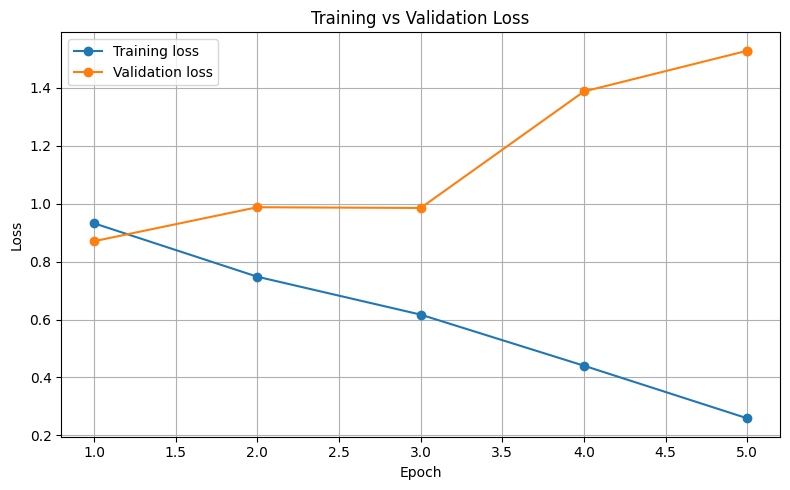

In [12]:
import matplotlib.pyplot as plt

# After training:
# trainer.train()

logs = pd.DataFrame(trainer.state.log_history)

# Separate train and eval logs
train_logs = logs[logs["loss"].notna()][["epoch", "loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_logs["epoch"], train_logs["loss"], marker="o", label="Training loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()